In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore', message='numpy.dtype size changed')

In [2]:
raw = pd.read_csv('./data/wine_vector_2.csv')
review = raw.copy(deep=True).drop(columns = ['Unnamed: 0'])
review.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,region
0,0,355,0.0,2,3.0,California,Napa Valley,Napa,0,0,0
1,1,318,1.0,2,2.0,Northern Spain,Toro,NaN,1,1,1
2,0,280,2.0,2,1.0,California,Knights Valley,Sonoma,2,2,2
3,0,386,3.0,2,1.0,Oregon,Willamette Valley,Willamette Valley,3,3,3
4,2,376,4.0,2,1.0,Provence,Bandol,NaN,4,4,4


In [3]:
# region = province + region_1 + region_2
review = review.drop(['province', 'region_1', 'region_2'], axis=1)
review.head()

,country,description,designation,points,price,variety,winery,region
0,0,355,0.0,2,3.0,0,0,0
1,1,318,1.0,2,2.0,1,1,1
2,0,280,2.0,2,1.0,2,2,2
3,0,386,3.0,2,1.0,3,3,3
4,2,376,4.0,2,1.0,4,4,4


In [4]:
metrics = list(review.columns)
metrics.remove('points')
metrics

['country',
 'description',
 'designation',
 'price',
 'variety',
 'winery',
 'region']

In [5]:
# standardize data
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis=0)) / np.std(raw_data, axis=0))
review[metrics] = standardize(review[metrics])
review.head()

,country,description,designation,points,price,variety,winery,region
0,-0.680918,1.656540,-0.844725,2,4.943627,-0.569715,-1.307175,-0.825488
1,-0.465540,1.121827,-0.844611,2,2.536439,-0.558069,-1.306907,-0.822071
2,-0.680918,0.572663,-0.844496,2,0.129251,-0.546423,-1.306638,-0.818653
3,-0.680918,2.104542,-0.844382,2,0.129251,-0.534776,-1.306370,-0.815235
4,-0.250163,1.960025,-0.844268,2,0.129251,-0.523130,-1.306102,-0.811817


In [6]:
features = review[metrics]
label = review['points']

smt = SMOTE(random_state=20)
    
X_train_old, X_test, Y_train_old, Y_test = train_test_split(features, label, 
                                                    test_size=0.20, 
                                                    random_state=0)
X_train, Y_train = smt.fit_sample(X_train_old, Y_train_old)
# raise XGBoost ValueError: feature_names mismatch
X_train = pd.DataFrame(X_train, columns=list(X_train_old.columns))
print('train/test set:', len(X_train), len(X_test))

train/test set: 266180 30186


In [7]:
# Random Forest
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth=30,
                                criterion='entropy')
# print('CVS:', np.mean(cross_val_score(forest, X_train, Y_train, cv=10)))

ACC: 0.798946531504671
Confusion Matrix:
 [[   63    30     5     0     0]
 [   25  1790   474   100     4]
 [    9   544  7578  1463   117]
 [    3   129  1321 10978   935]
 [    0     4   126   780  3708]]
Overall Report:
               precision    recall  f1-score   support

           1       0.63      0.64      0.64        98
           2       0.72      0.75      0.73      2393
           3       0.80      0.78      0.79      9711
           4       0.82      0.82      0.82     13366
           5       0.78      0.80      0.79      4618

   micro avg       0.80      0.80      0.80     30186
   macro avg       0.75      0.76      0.75     30186
weighted avg       0.80      0.80      0.80     30186



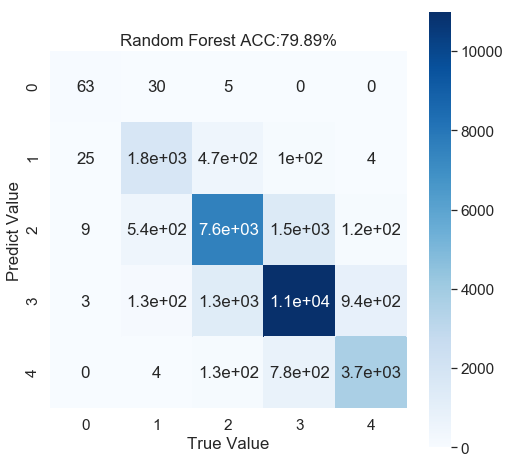

In [8]:
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)

acc = accuracy_score(Y_test, Y_test_predict)
print('ACC:', acc)
mat = confusion_matrix(Y_test, Y_test_predict)
print('Confusion Matrix:\n', mat)

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
sns.heatmap(mat, square=True, annot=True, cmap='Blues')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('Random Forest ACC:{0:.2f}%'.format(acc * 100))
plt.savefig('./images/randomForest.png')
print('Overall Report:\n', classification_report(Y_test, Y_test_predict))

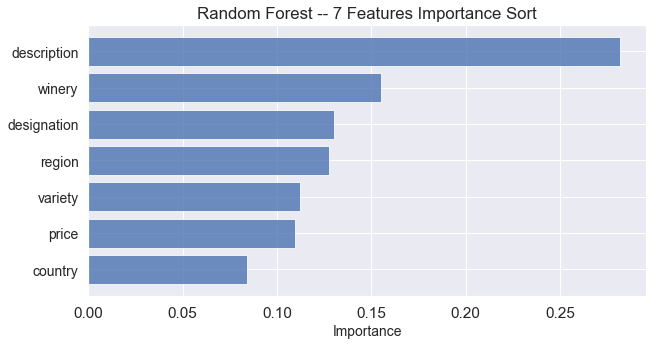

In [9]:
# Random Forest feature importance visulization
feature_names = X_train.columns
feature_imports = forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(len(X_train.columns), "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10, 5))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.title('Random Forest -- {} Features Importance Sort'.format(len(X_train.columns)))
plt.savefig('./images/randomForestFeatImp.jpg')

In [10]:
# XGBoost
xgb_reg = xgb.XGBClassifier(n_estimators=100,
                               max_depth=30,
                               random_state=0)
# print('CVS:', np.mean(cross_val_score(xgb_reg, X_train, Y_train, cv=10)))

ACC: 0.808288610614192
Confusion Matrix:
 [[   65    26     7     0     0]
 [   37  1765   496    89     6]
 [    9   490  7681  1419   112]
 [    4   105  1228 11212   817]
 [    0     6   114   822  3676]]
Overall Report:
               precision    recall  f1-score   support

           1       0.57      0.66      0.61        98
           2       0.74      0.74      0.74      2393
           3       0.81      0.79      0.80      9711
           4       0.83      0.84      0.83     13366
           5       0.80      0.80      0.80      4618

   micro avg       0.81      0.81      0.81     30186
   macro avg       0.75      0.77      0.76     30186
weighted avg       0.81      0.81      0.81     30186



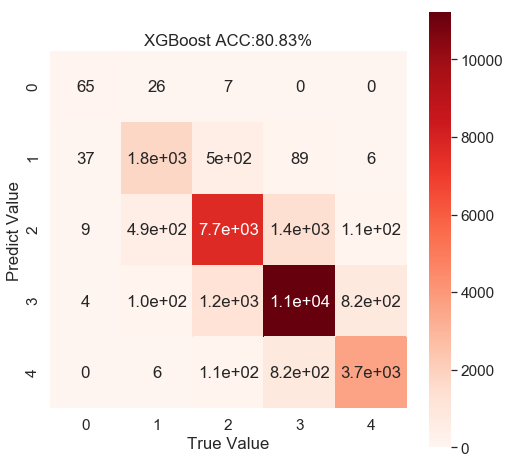

In [13]:
xgb_reg.fit(X_train, Y_train)
Y_test_predict = xgb_reg.predict(X_test)

acc = accuracy_score(Y_test, Y_test_predict)
print('ACC:', acc)
mat = confusion_matrix(Y_test, Y_test_predict)
print('Confusion Matrix:\n', mat)

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
sns.heatmap(mat, square=True, annot=True, cmap='Reds')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('XGBoost ACC:{0:.2f}%'.format(acc * 100))
plt.savefig('./images/XGBoost.png')
print('Overall Report:\n', classification_report(Y_test, Y_test_predict))

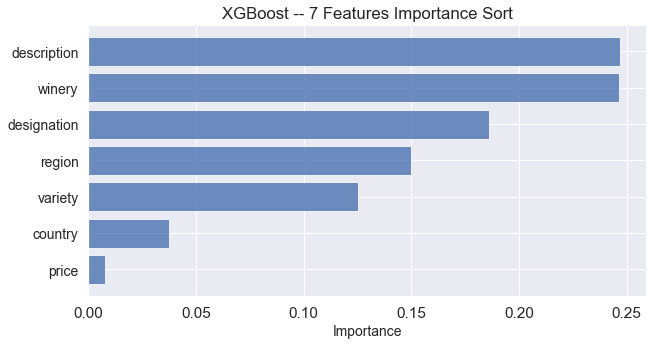

In [12]:
# XGBoost feature importance visulization
feature_names = X_train.columns
feature_imports = xgb_reg.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(len(X_train.columns), "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10, 5))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.title('XGBoost -- {} Features Importance Sort'.format(len(X_train.columns)))
plt.savefig('./images/XGBoostFeatImp.jpg')